# Importación de librerías

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from src.video_processing_functions import *
from src.utility_functions import *

# Experimentos para el algoritmo *Frequency Domain Image Blur Measure* (FM)

## Medición sobre todo el frame

A continuación se presenta un experimento para medir el tiempo de ejecución del algoritmo FM sobre todo el frame. Utilizaremos el video [focus_video.mov](resources/focus_video.mov) para la experimentación. 

In [2]:
# Define the path to the video
video_path = 'resources/focus_video.mov'

La función `detect_max_focus_points` recibe el path del video y retorna una lista con todas las medidas de FM para cada frame, una lista con los puntos de mayor enfoque y el máximo enfoque alcanzado.

In [3]:
quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(video_path)

Se extraeran los frames de mayor enfoque y se utilizarán en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame. 

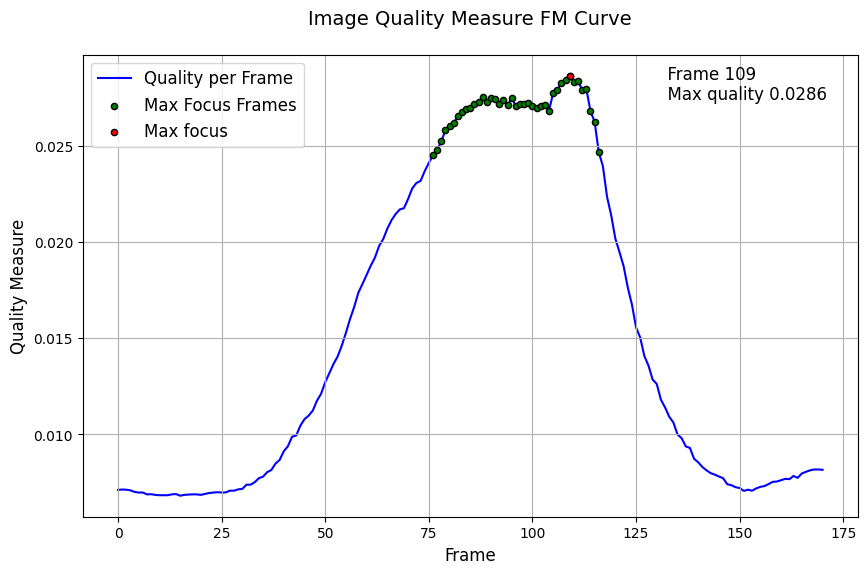

In [4]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [5]:
print('Max focus points:', max_focus_frames)

Max focus points: [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]


Como se puede ver en la gráfica superior, la calidad de la imagen es variable a lo largo del video. Los frames de buen enfoque comienzan a partir del frame 76 y se extienden hasta el frame 116. Se alcanza el **punto de máxima calidad de 0.0286 en el frame 109**.

A continuación se presenta un video donde se visualiza un recuadro sobre el frame completo, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad. Para ello se utiliza la función `display_video_highlight_max_focus` que recibe el path del video, la lista de los puntos de mayor enfoque y la lista completa de las medidas de enfoque.

In [6]:
display_video_highlight_max_focus(
    video_path = video_path, 
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 76 y 116.

## Medición sobre una ROI ubicada en el centro de la imagen

Área de la ROI de 5 o 10% del tamaño de la imagen original.

---

A continuación se experimenta con una región de interés (ROI) del 5% del tamaño de la imagen original.

In [7]:
roi_percentage = 0.05

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

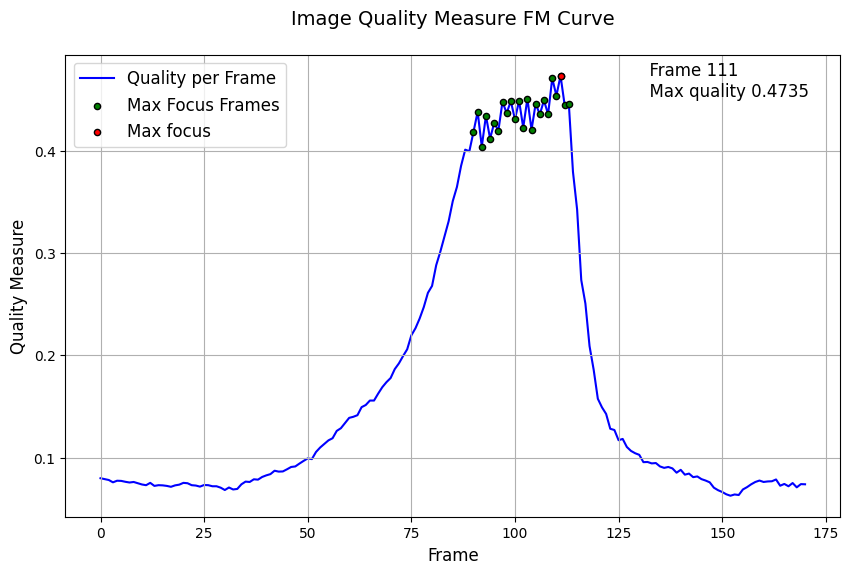

In [8]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

Podemos ver en la imagen superior que la calidad de la imagen es variable a lo largo del video. La calidad alcanza un buen enfoque a partir del frame 90 y se extiende hasta el frame 113. Se alcanza un **punto de máxima calidad de 0.4735 en el frame 111**. Nótese que la calidad de la imagen en la ROI es mayor que la calidad de la imagen completa, pero se alcanzan valores de calidad considerados altos unos frames después.

In [9]:
print('Max focus points:', max_focus_frames)

Max focus points: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [25]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 90 y 113. Además, se puede observar la ROI en el centro de la imagen, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad.

Ahora se experimenta con una región de interés (ROI) del 10% del tamaño de la imagen original.

In [10]:
roi_percentage = 0.1

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

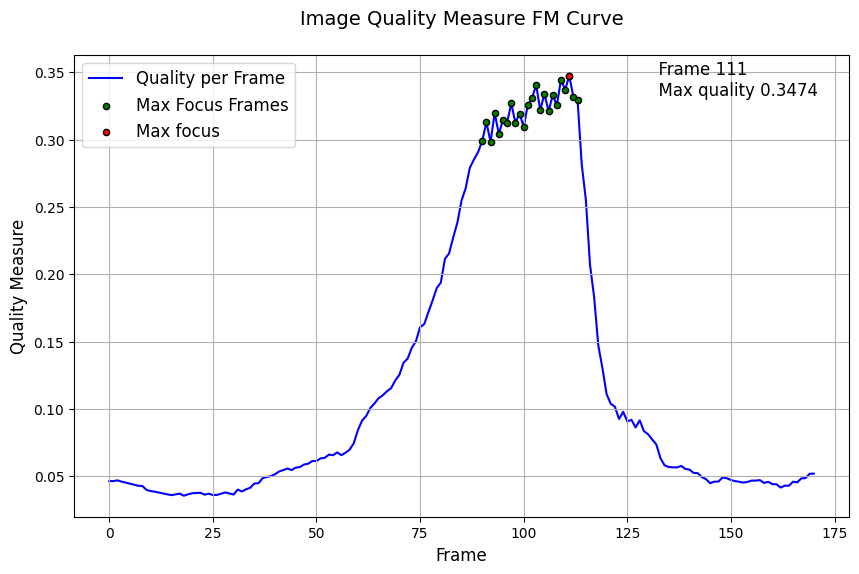

In [11]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [12]:
print('Max focus points:', max_focus_frames)

Max focus points: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


Podemos ver en la imagen superior que el frame donde se alcanza la máxima calidad es el mismo que en el caso anterior, es decir, el frame 111. La calidad de la imagen sin embargo es menor que en el caso anterior. Esto puede deberse a que la ROI es más grande y por lo tanto analiza más información de la imagen. Por otro lado, el rango de frames de buena calidad es el mismo que en el caso anterior, es decir, entre los frames 90 y 113.

In [29]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

Igualmente, en el video se puede visualizar el mismo comportamiento que en la gráfica, donde la única diferencia es que la ROI es más grande y los valores de calidad son menores en comparación con el caso anterior.

## Medición sobre una matriz de enfoque

Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

----

Para este experimento, la función [detect_max_focus_points](src/video_processing_functions.py) el tamaño de la ROI y el tamaño de la matriz de enfoque. En la función se computa una matríz de enfoque compuesta por un arreglo de $N \times M$ elementos rectangulares equiespaciados y se calcula la calidad de la imagen considerando el promedio de la calidad de cada elemento de la matriz, para obtener un valor de calidad correspondiente al frame.

In [13]:
N = 3
M = 3
roi_percentage = 0.2

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    N = N, 
    M = M, 
    roi_percentage = roi_percentage
)

Al dividir cada frame en una cuadrícula de $𝑁 \times M$ elementos rectangulares, se obtiene una medida de enfoque para cada sección, permitiendo detectar variaciones locales que podrían perderse en una evaluación global. Promediar estas medidas ofrece una representación precisa de la calidad de enfoque del frame completo, suavizando las fluctuaciones locales. En comparación con métodos que evalúan el frame completo o subregiones fijas, el enfoque de cuadrículas proporciona una mejor adaptabilidad y precisión.

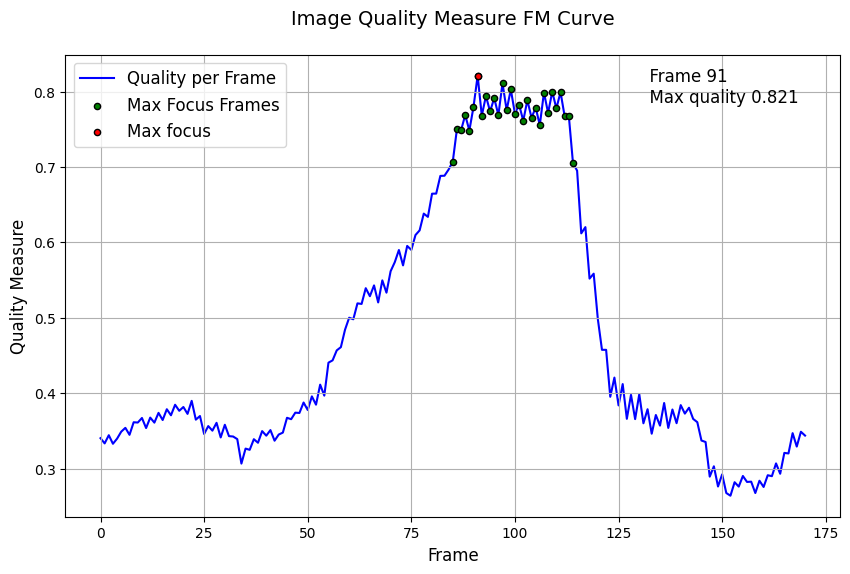

In [14]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [15]:
print('Max focus points:', max_focus_frames)

Max focus points: [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]


En la imagen superior se muestra la calidad de la imagen en función del frame para una matriz de enfoque de 3x3. Se puede observar que la calidad sigue una tendencia similar a las experimentaciones anteriores. Sin embargo, **se alcanza un punto de máxima calidad mayor, en este caso de 0.8210 en el frame 91**. Esto puede deberse a que la matriz de enfoque permite detectar variaciones locales que podrían perderse en una evaluación global de la imagen completa. Los puntos de enfoque de buena calidad comienzan en el frame 85 y se extienden hasta el frame 114.

In [33]:
display_video_highlight_max_focus(
    video_path = video_path, 
    M = N,
    N = M,
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En la visualización del video se puede observar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 85 y 114. Además, se puede observar la matriz de enfoque en el centro de la imagen, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad.

A continuación, se experimenta con cuatro matrices de enfoque de tamaños 5x3, 7x5, 5x5, 7x7.

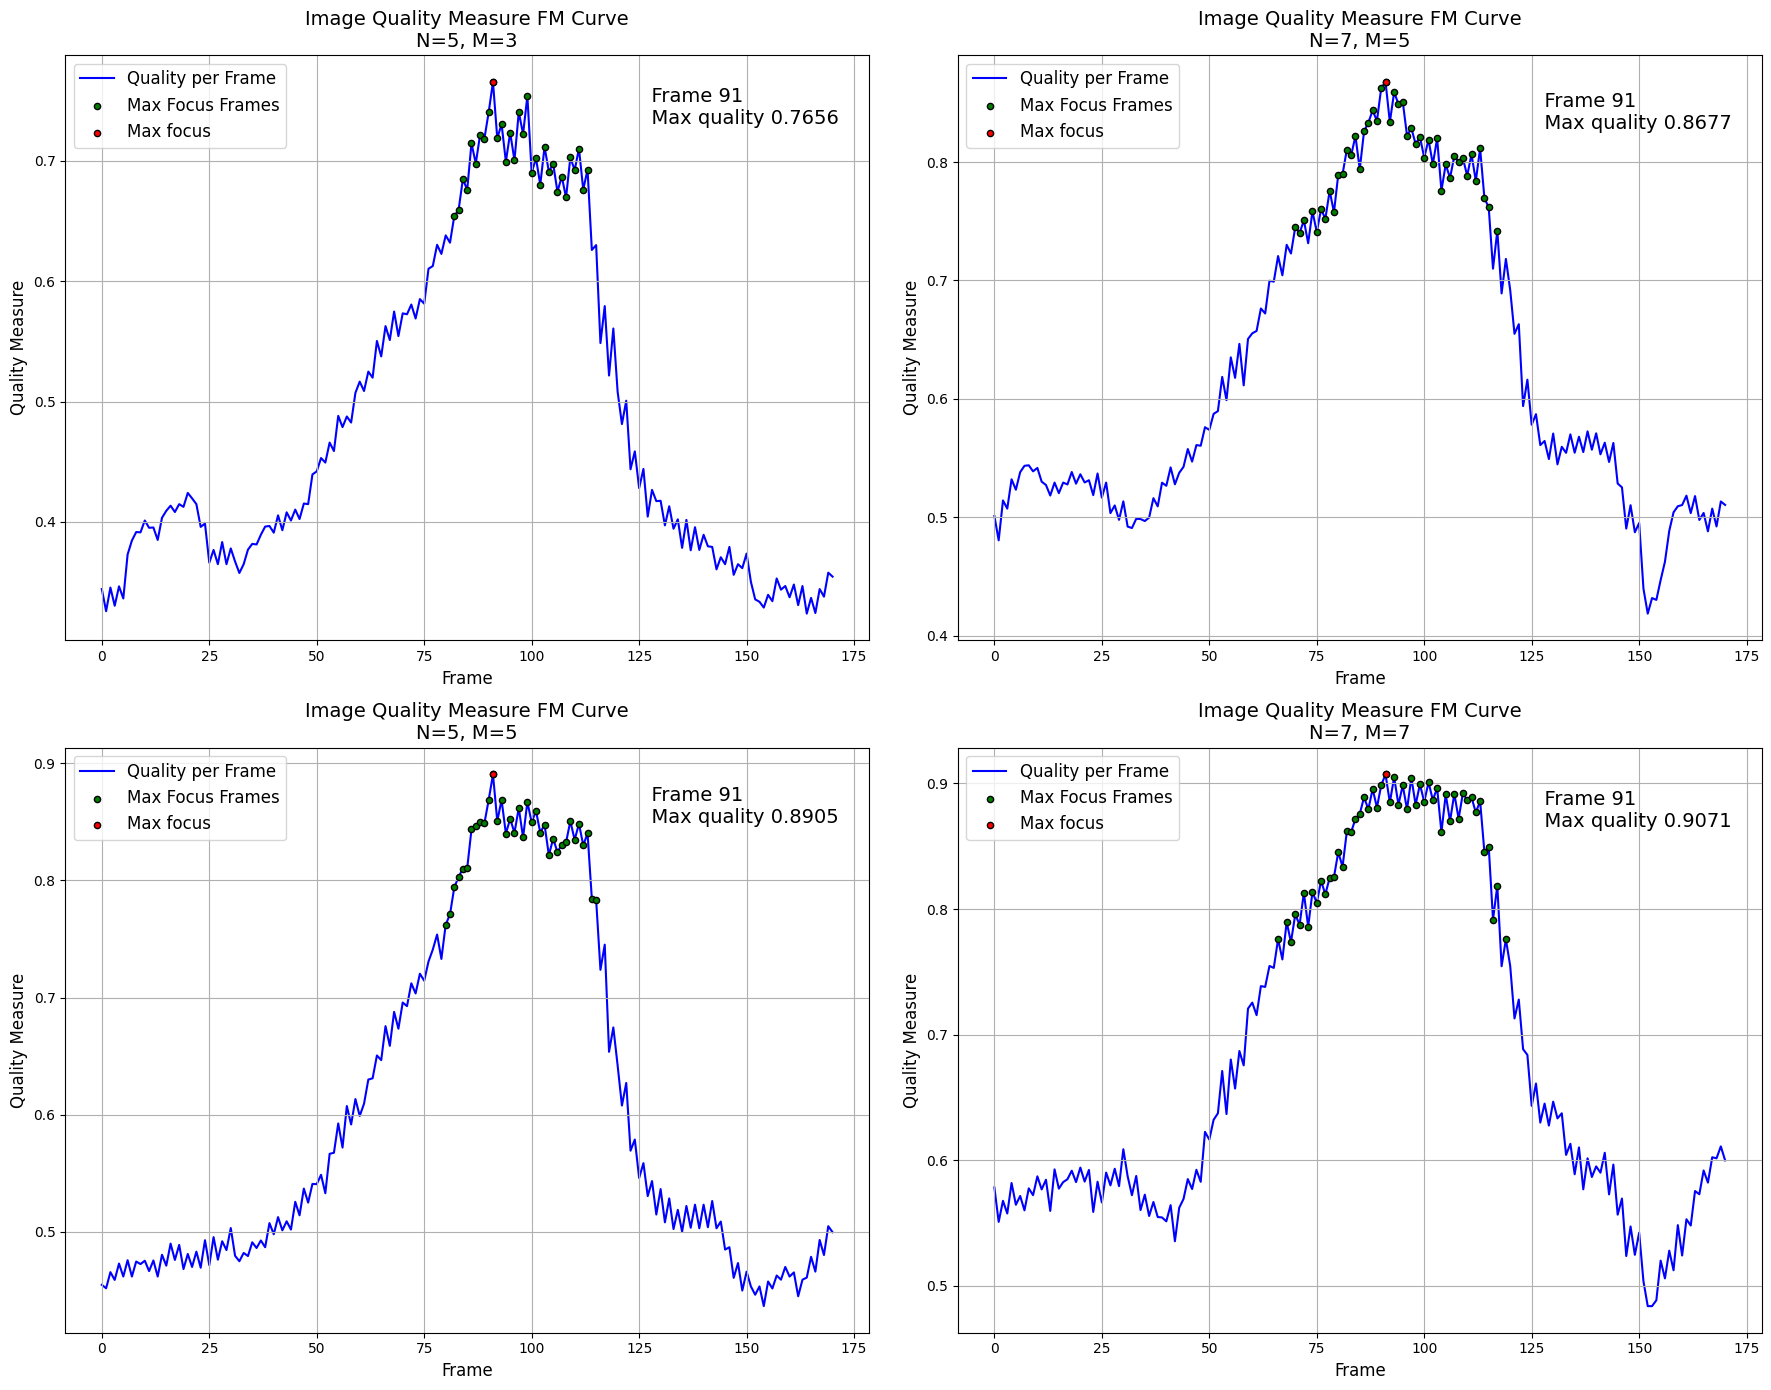

In [3]:
variations = [
    {'N': 5, 'M': 3, 'roi_percentage': 0.2},
    {'N': 7, 'M': 5, 'roi_percentage': 0.2},
    {'N': 5, 'M': 5, 'roi_percentage': 0.2},
    {'N': 7, 'M': 7, 'roi_percentage': 0.2}
]

plot_quality_measurements_on_2x2_grid(variations, video_path)

En las cuatro imágenes superiores se pueden experimentos ejecutados con cuatro diferentes matrices de enfoque. Se puede observar que la calidad de la imagen mantiene una tendencia similar a las experimentaciones anteriores. Igualmente, **el punto de máxima calidad se alcanza en el frame 91**. Sin embargo, se puede observar que la calidad de la imagen es mayor en las matrices de enfoque con mayor cantidad de elementos. 

Algo a notar es que **la matríz 7x7 alcanza una calidad de 0.9071**, manteniendo valores considerados de buen enfoque en un rango de frames mayor a los experimentos anteriores. 

In [4]:
show_video_highlight_on_2x2_grid(variations, video_path)

# Experimentos utilizando el algoritmo (X)

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure 
operators in shapefrom focus.

In [4]:
def gray_level_variance(image: np.ndarray) -> float:
    """
    Calculate the Gray-level Variance (STA3) of an image.
    
    Args:
    image (np.ndarray): The input grayscale image.
    
    Returns:
    float: The gray-level variance of the input image.
    """
    mean = np.mean(image)
    variance = np.mean((image - mean) ** 2)
    return variance

In [8]:
quality_measurements = calculate_video_quality(
    video_path=video_path,
    quality_measure_function=gray_level_variance
    )

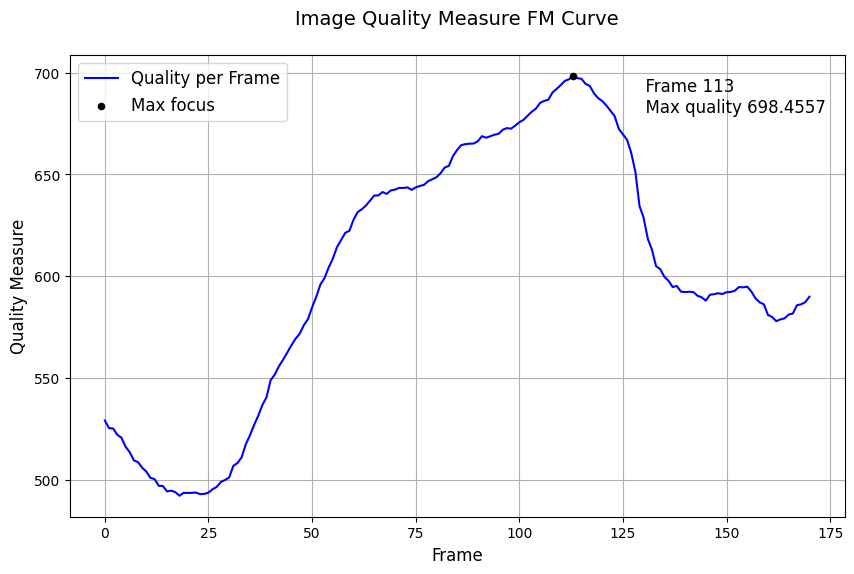

In [7]:
# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 15, max_focus_value-20, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [12]:
quality_measurements = calculate_video_quality(
    video_path=video_path,
    quality_measure_function=gray_level_variance,
    roi_percentage=0.05
    )

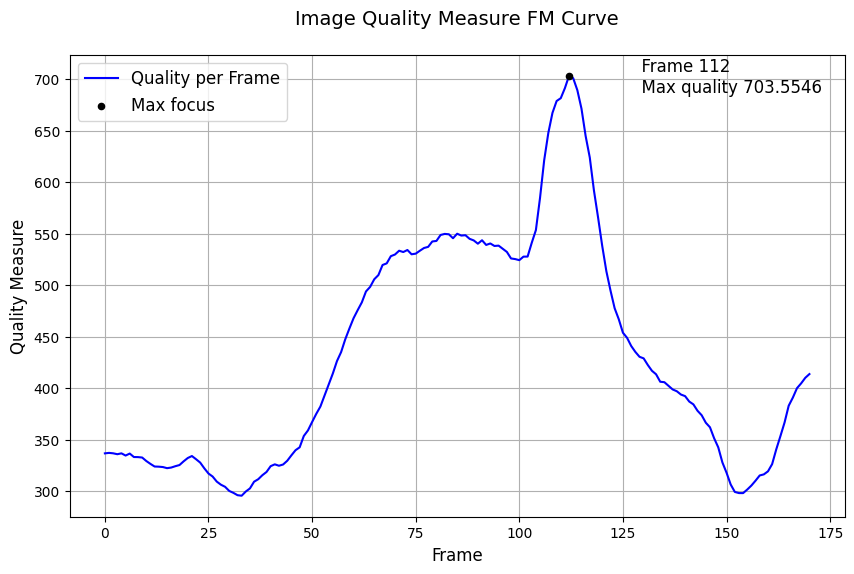

In [13]:
# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 15, max_focus_value-20, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [10]:
quality_measurements, max_focus_points = calculate_video_quality(
    video_path=video_path,
    quality_measure_function=gray_level_variance,
    roi_percentage=0.1
    )

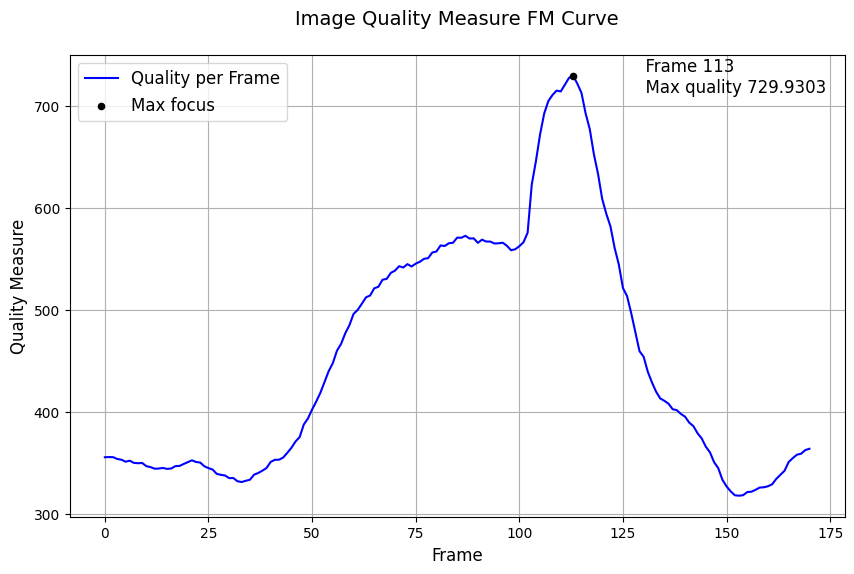

In [11]:
# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 15, max_focus_value-20, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

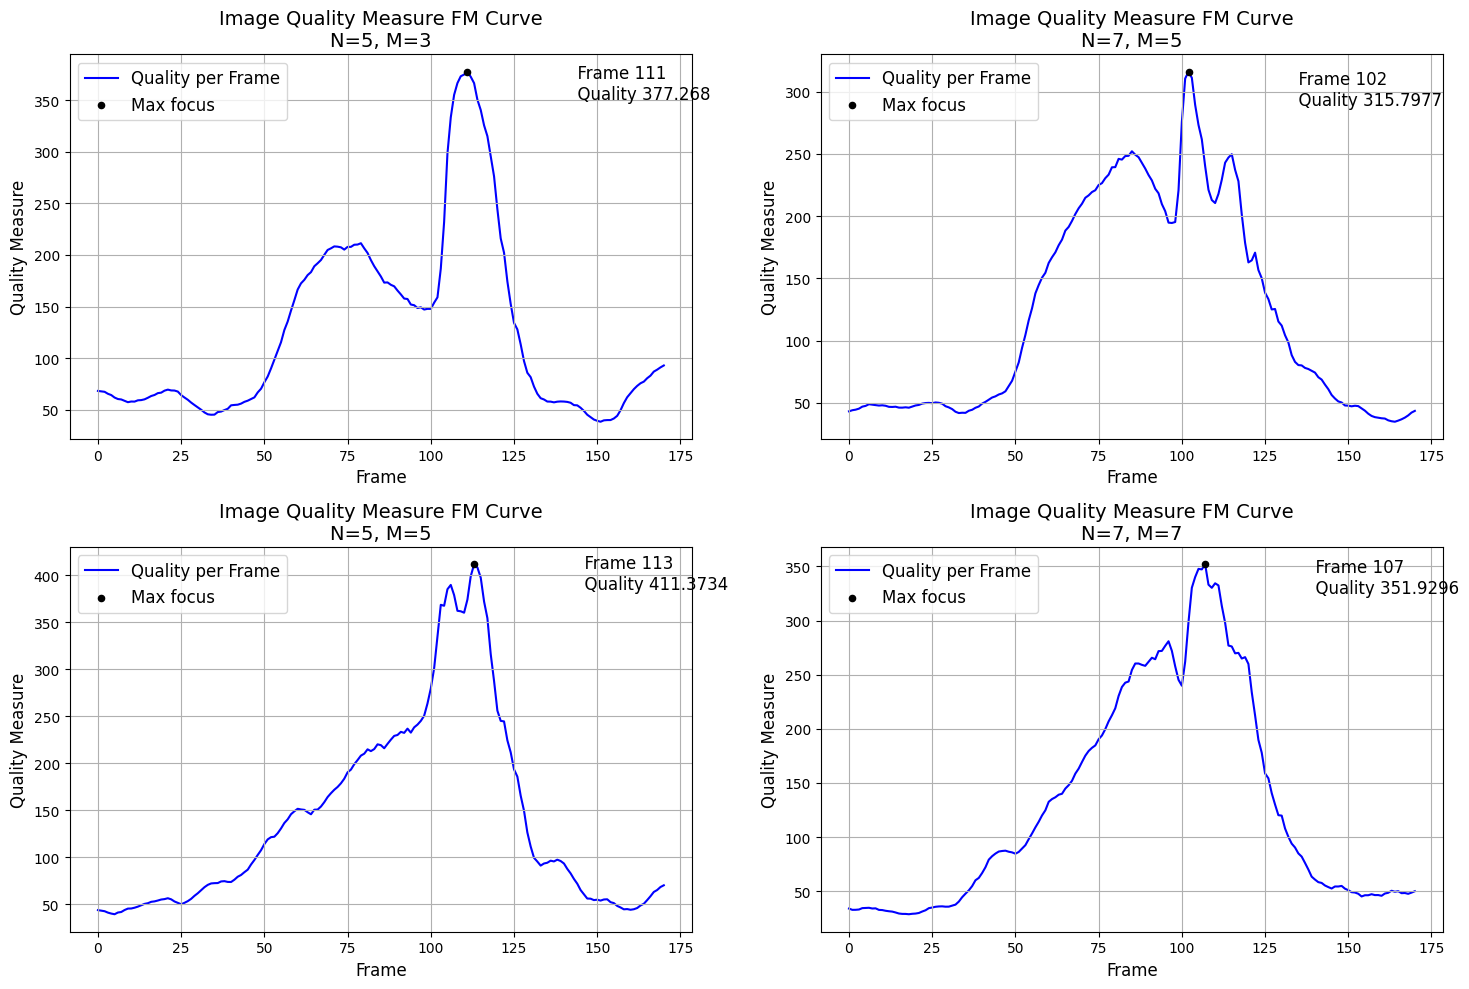

In [6]:
variations = [
    {'N': 5, 'M': 3, 'roi_percentage': 0.2},
    {'N': 7, 'M': 5, 'roi_percentage': 0.2},
    {'N': 5, 'M': 5, 'roi_percentage': 0.2},
    {'N': 7, 'M': 7, 'roi_percentage': 0.2}
]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, var in enumerate(variations):
    # Compute the quality measurements of the video with a grid
    quality_measurements_grid = calculate_video_quality_grid(
        video_path=video_path, 
        quality_measure_function=gray_level_variance,
        N=var['N'], 
        M=var['M'], 
        roi_percentage=var['roi_percentage']
        )
    
    # Find the max focus value and its index
    max_focus_index = quality_measurements_grid.index(max(quality_measurements_grid))
    max_focus_value = round(max(quality_measurements_grid), 4)

    # Select the subplot
    ax = axs[i//2, i%2]

    # Graph the quality measure curve
    ax.plot(quality_measurements_grid, label='Quality per Frame', color='blue', zorder=1)

    # Highlight the max focus value
    ax.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
    ax.text(max_focus_index + 30, max_focus_value - 30, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

    # Add labels, title, and legend
    ax.set_xlabel('Frame', fontsize=12)
    ax.set_ylabel('Quality Measure', fontsize=12)
    ax.set_title(f'Image Quality Measure FM Curve\nN={var["N"]}, M={var["M"]}', fontsize=14)

    # Add grid lines
    ax.grid(True)

    # Add legend
    ax.legend(fontsize=12)

# Adjust the layout
plt.tight_layout()

In [9]:
import pywt

def wavelet_focus_measure(image: np.ndarray) -> float:
    """
    Calculate the Wavelet-based focus measure of an image.
    
    Args:
    image (np.ndarray): The input grayscale image.
    
    Returns:
    float: The wavelet-based focus measure of the input image.
    """
    coeffs2 = pywt.dwt2(image, 'db2')
    LL, (LH, HL, HH) = coeffs2
    focus_measure = np.sum(np.abs(LH)) + np.sum(np.abs(HL)) + np.sum(np.abs(HH))
    return focus_measure

In [11]:
quality_measurements = calculate_video_quality_grid(
    video_path=video_path,
    N=3, 
    M=3,
    quality_measure_function=wavelet_focus_measure,
    roi_percentage=0.2
    )

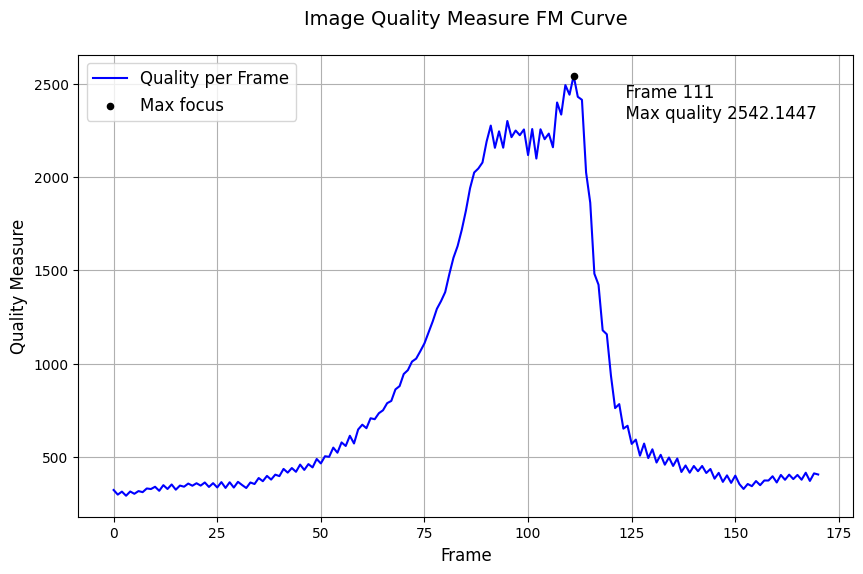

In [19]:

# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 10, max_focus_value-250, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

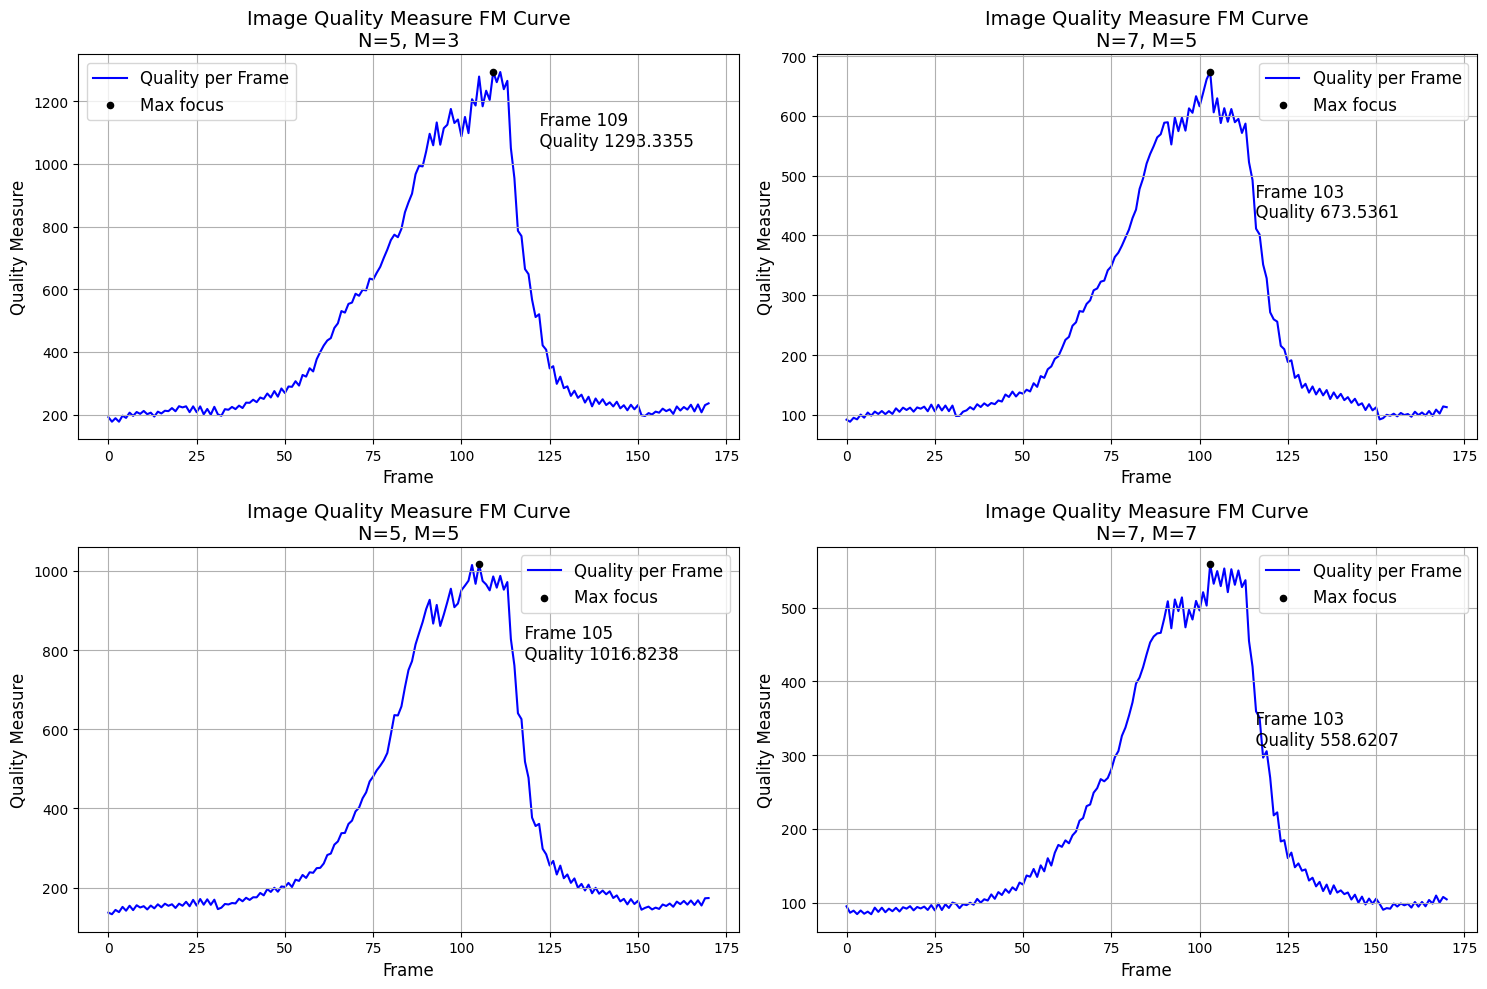

In [20]:
variations = [
    {'N': 5, 'M': 3, 'roi_percentage': 0.2},
    {'N': 7, 'M': 5, 'roi_percentage': 0.2},
    {'N': 5, 'M': 5, 'roi_percentage': 0.2},
    {'N': 7, 'M': 7, 'roi_percentage': 0.2}
]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, var in enumerate(variations):
    # Compute the quality measurements of the video with a grid
    quality_measurements_grid = calculate_video_quality_grid(
        video_path=video_path, 
        quality_measure_function=wavelet_focus_measure,
        N=var['N'], 
        M=var['M'], 
        roi_percentage=var['roi_percentage']
        )
    
    # Find the max focus value and its index
    max_focus_index = quality_measurements_grid.index(max(quality_measurements_grid))
    max_focus_value = round(max(quality_measurements_grid), 4)

    # Select the subplot
    ax = axs[i//2, i%2]

    # Graph the quality measure curve
    ax.plot(quality_measurements_grid, label='Quality per Frame', color='blue', zorder=1)

    # Highlight the max focus value
    ax.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
    ax.text(max_focus_index + 15, max_focus_value - 250, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

    # Add labels, title, and legend
    ax.set_xlabel('Frame', fontsize=12)
    ax.set_ylabel('Quality Measure', fontsize=12)
    ax.set_title(f'Image Quality Measure FM Curve\nN={var["N"]}, M={var["M"]}', fontsize=14)

    # Add grid lines
    ax.grid(True)

    # Add legend
    ax.legend(fontsize=12)

# Adjust the layout
plt.tight_layout()